iterations per fold: 4000
Validation fold :  1
iteration 0 : cost 0.695283
iteration 1000 : cost 0.001124
iteration 2000 : cost 0.000353
iteration 3000 : cost 0.000177
Validation fold :  2
iteration 0 : cost 0.706589
iteration 1000 : cost 0.000891
iteration 2000 : cost 0.000326
iteration 3000 : cost 0.000194
Validation fold :  3
iteration 0 : cost 0.695811
iteration 1000 : cost 0.000690
iteration 2000 : cost 0.000343
iteration 3000 : cost 0.000220
Validation fold :  4
iteration 0 : cost 0.674739
iteration 1000 : cost 0.000993
iteration 2000 : cost 0.000364
iteration 3000 : cost 0.000184
Validation fold :  5
iteration 0 : cost 0.681118
iteration 1000 : cost 0.000791
iteration 2000 : cost 0.000320
iteration 3000 : cost 0.000198
Validation fold :  6
iteration 0 : cost 0.701590
iteration 1000 : cost 0.001128
iteration 2000 : cost 0.000374
iteration 3000 : cost 0.000194

Training accuracy:  1.0 Validn Accuracy:  0.9585661080074487

Pred   1  0
Ac 1   180 0
   0   0 178

accuracy =  1.0 sens

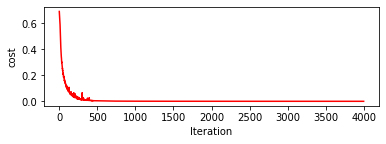

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat_contents = loadmat('data5.mat')
data = mat_contents['x']
np.random.shuffle(data)

def init_data(): 
    X = np.array(data[:2148, :-1], dtype = float)
    y = np.array(data[:2148, -1], dtype = int)
    X = (X - X.mean(axis = 0))/X.std(axis = 0)
    return X, y
def relu_forward(x):
    a = x
    a[a<=0] = 0
    theta = x
    return a, theta
def relu_backward(dout, theta):
    x = theta
    dx = None
    dx = np.ones(x.shape)
    dx[x<=0] = 0
    dx = dx * dout
    return dx
def collinear_forward(x, w, b):
    z = x.dot(w) + b
    theta = (x, w, b)
    return z, theta
def collinear_backward(dout, theta):
    x, w, b = theta
    db = np.sum(dout, axis = 0)
    dw = x.T.dot(dout)
    dx = dout.dot(w.T)
    return dx, dw, db

print('iterations per fold: 4000')
class MLP(object):

    def __init__(self, input_size, h1, h2, num_classes, std=1e-4):
        self.W1 = std * np.random.randn(input_size, h1)
        self.b1 = np.zeros(h1)
        self.W2 = std * np.random.randn(h1, h2)
        self.b2 = np.zeros(h2)
        self.W3 = std * np.random.randn(h2, num_classes)
        self.b3 = np.zeros(num_classes)

    def cost(self, X, y = None, lambda1 = 0.0): 
        N, D = X.shape
        scores = None
        z1, af_theta1 = collinear_forward(X, self.W1, self.b1)
        h1, relu_theta1 = relu_forward(z1)
        z2, af_theta2 = collinear_forward(h1, self.W2, self.b2)
        h2, relu_theta2 = relu_forward(z2)
        z3, af_theta3 = collinear_forward(h2, self.W3, self.b3)
        scores = z3

        if y is None:
            return scores

        cost = None
        scores -= scores.max()
        scores_exp = np.exp(scores)
        correct_scores = scores[range(N), y]
        correct_scores_exp = np.exp(correct_scores)
        cost = np.sum(-np.log(correct_scores_exp / np.sum(scores_exp, axis = 1))) / N
        cost += 0.5 * lambda1 * (np.sum(self.W1 * self.W1) + np.sum(self.W2 * self.W2) + np.sum(self.W3 * self.W3))

        num = correct_scores_exp
        denom = np.sum(scores_exp, axis = 1)
        mask = (np.exp(z3)/denom.reshape(scores.shape[0],1))
        mask[range(N),y] = -(denom - num)/denom
        mask /= N
        dz3 = mask

        dh2, dw3, db3 = collinear_backward(dz3, af_theta3)
        dz2 = relu_backward(dh2, relu_theta2)
        dh1, dw2, db2 = collinear_backward(dz2, af_theta2)
        dz1 = relu_backward(dh1, relu_theta1)
        dx, dw1, db1 = collinear_backward(dz1, af_theta1)
        
        dw3 = dw3 + lambda1 * self.W3
        dw2 = dw2 + lambda1 * self.W2
        dw1 = dw1 + lambda1 * self.W1

        wgrad = (dw1, dw2, dw3)
        bgrad = (db1, db2, db3)

        return cost, wgrad, bgrad

    def train(self, X, y, X_val, y_val, alpha=0.001, alpha_decay=0.95, lambda1=5e-6, num_iters=100, batch_size=200):
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)
        cost_history = []
        train_acc_history = []
        val_acc_history = []

        for iter in range(num_iters):

            ind = np.random.choice(num_train, batch_size)
            X_batch = X[ind,:]
            y_batch = y[ind]
            
            cost, wgrad, bgrad = self.cost(X_batch, y = y_batch, lambda1 = lambda1)
            cost_history.append(cost)

            dw1, dw2, dw3 = wgrad
            db1, db2, db3 = bgrad

            self.W1 -= alpha * dw1
            self.W2 -= alpha * dw2
            self.W3 -= alpha * dw3
            self.b1 -= alpha * db1
            self.b2 -= alpha * db2
            self.b3 -= alpha * db3


            if iter % 1000 == 0:
                print('iteration %d : cost %f' % (iter, cost))


            if iter % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                alpha *= alpha_decay


        return {'cost_history' : cost_history, 'train_acc_history' : train_acc_history, 'val_acc_history' : val_acc_history}


    def predict(self, X):
        y_pred = np.argmax(self.cost(X), axis = 1)
        return y_pred


input_size = 72
hidden_size1 = 30
hidden_size2 = 30
num_classes = 2
num_inputs = 1790
std = 0.1
alpha = 0.3
batch_size = 1024
lambda1 = 0.01
num_iters = 4000

X_tot, y_tot = init_data()

train_acc , val_acc = 0, 0
costs = np.empty((6, num_iters))
val_accs = []
train_accs = []

for k in range(6):
    
    X = X_tot[0 : 1790]
    y = y_tot[0 : 1790]
    X_val = X_tot[1790 :]
    y_val = y_tot[1790 :]
    
    Net = MLP(input_size, hidden_size1, hidden_size2, num_classes, std)
    print("Validation fold : " , k + 1)
    stats = Net.train(X, y, X_val, y_val, num_iters=num_iters, alpha=alpha, batch_size=batch_size, lambda1=0.0)
    costs[k] = np.asarray(stats['cost_history'])
    val_accs = np.asarray(stats['val_acc_history'])
    train_accs = np.asarray(stats['train_acc_history'])
    train_acc += train_accs
    val_acc += val_accs

    X_tot[0 : 358] = X_val
    X_tot[358 : ] = X
    y_tot[0 : 358] = y_val
    y_tot[358 : ] = y

train_acc = train_acc / 6
val_acc = val_acc / 6

print('\nTraining accuracy: ', train_acc[-1], 'Validn Accuracy: ',val_acc[-1])
cost_hist = np.mean(costs, axis = 0)

plt.subplot(2, 1, 1)
plt.plot(cost_hist, 'r-')
plt.xlabel('Iteration')
plt.ylabel('cost')

y_pred = Net.predict(X_val)
tp, tn, fp, fn = 0, 0, 0, 0
for i in range(len(y_val)):
    if y_pred[i] == 0 and  y_val[i] == 0:
        tn += 1
    elif y_pred[i] == 1 and  y_val[i] == 0:
        fp += 1
    elif y_pred[i] == 0 and  y_val[i] == 1:
        fn += 1
    elif y_pred[i] == 1 and  y_val[i] == 1:
        tp += 1
print('\nPred   1  0')
print('Ac 1  ',tp, fp)
print('   0  ',fn, tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\naccuracy = ", accuracy, "sensitivity = ", sensitivity, "specificity = ", specificity)
